### STEP 1: IMPORTING ALL THE NECESARY LIBRARIES:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


### STEP 2: SETTING UP THE DATASET PATHS AND DIRECTORIES: 


In [2]:
# Set the path to the dataset
dataset_path = "C:/Users/uday8/Documents/SEM_5/RM/Dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "C:/Users/uday8/Documents/SEM_5/RM/Dataset/Training")
test_dir = os.path.join(dataset_path, "C:/Users/uday8/Documents/SEM_5/RM/Dataset/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]


### STEP 3: LOADING AND PREPROCESSING THE DATASET: 

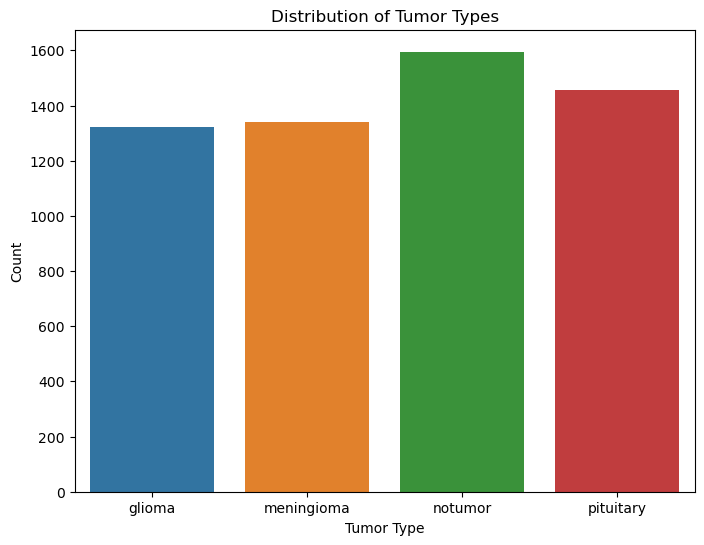

In [3]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()


### STEP 4: VISUALIZING IMAGES FOR EACH TUMOR TYPES: 

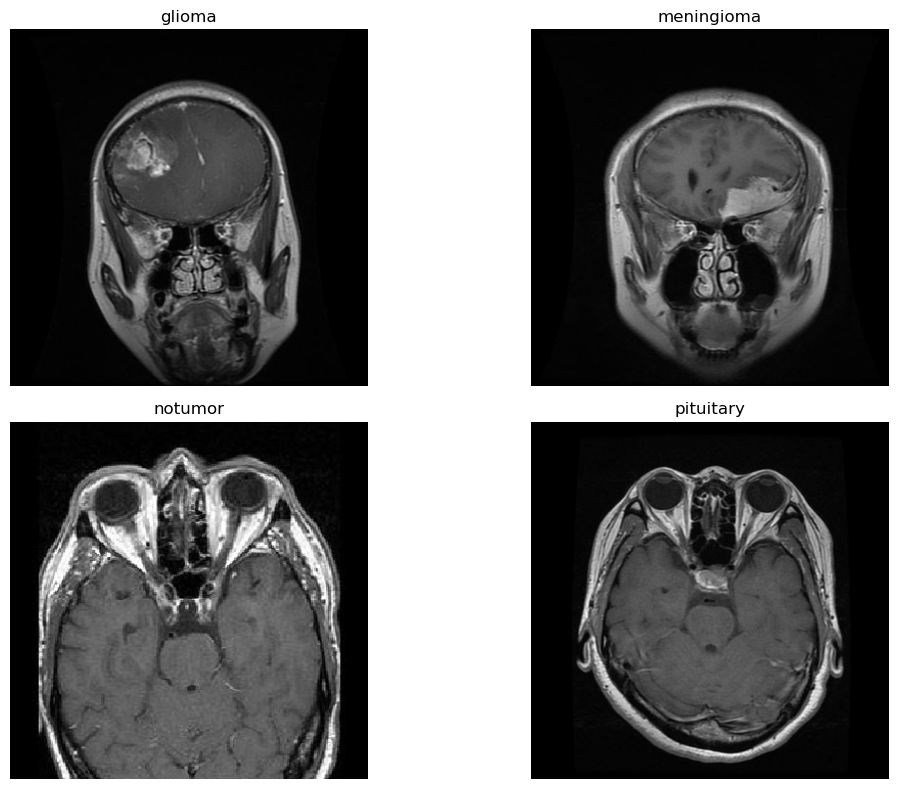

In [4]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

### STEP 5: SETTING UP IMAGE SIZE ,BATCH SIZE, AND EPOCHES:

In [5]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 30

### STEP 6: DATA AUGMENTATION AND PREPROCESSING:

In [6]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### STEP 7: BUILDING THE MODEL ARTITECHURE

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (150,150, 3)  # Adjust the input size if needed

# Create an input layer
input_layer = Input(shape=input_shape)

# Define the number of filters in each dense block
num_filters = 64  # You can adjust this value

# Initial Convolution
x = Conv2D(num_filters, (7, 7), strides=(2, 2), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Define the number of dense blocks and layers per dense block
num_dense_blocks = 4  # You can adjust this value
layers_per_block = [6, 12, 24, 16]  # You can adjust the number of layers per block

# Dense Blocks
for block in range(num_dense_blocks):
    for layer in range(layers_per_block[block]):
        # Bottleneck layer (1x1 Conv)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(4 * num_filters, (1, 1), padding='same')(x)

        # Convolution layer (3x3 Conv)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(num_filters, (3, 3), padding='same')(x)

    # Transition layer (1x1 Conv followed by 2x2 AveragePooling)
    if block < num_dense_blocks - 1:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(num_filters, (1, 1), padding='same')(x)
        x = AveragePooling2D((2, 2))(x)
        num_filters = num_filters * 2  # Double the number of filters in each transition

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully Connected Layer
output_layer = Dense(4, activation='softmax')(x)  # Adjust the number of output classes

# Create the DenseNet model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model (you can choose the optimizer and loss function)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 64)        9472      
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 75, 75, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 38, 38, 64)       256   

 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 19, 19, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 19, 19, 512)       66048     
                                                                 
 batch_normalization_17 (Bat  (None, 19, 19, 512)      2048      
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 19, 19, 512)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 19, 19, 128)       589952    
                                                                 
 batch_normalization_18 (Bat  (None, 19, 19, 128)      512       
 chNormalization)                                                
          

 batch_normalization_34 (Bat  (None, 19, 19, 128)      512       
 chNormalization)                                                
                                                                 
 activation_34 (Activation)  (None, 19, 19, 128)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 19, 19, 512)       66048     
                                                                 
 batch_normalization_35 (Bat  (None, 19, 19, 512)      2048      
 chNormalization)                                                
                                                                 
 activation_35 (Activation)  (None, 19, 19, 512)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 19, 19, 128)       589952    
                                                                 
 batch_normalization_36 (Bat  (None, 19, 19, 128)      512       
 chNormali

 activation_51 (Activation)  (None, 9, 9, 256)         0         
                                                                 
 conv2d_51 (Conv2D)          (None, 9, 9, 1024)        263168    
                                                                 
 batch_normalization_52 (Bat  (None, 9, 9, 1024)       4096      
 chNormalization)                                                
                                                                 
 activation_52 (Activation)  (None, 9, 9, 1024)        0         
                                                                 
 conv2d_52 (Conv2D)          (None, 9, 9, 256)         2359552   
                                                                 
 batch_normalization_53 (Bat  (None, 9, 9, 256)        1024      
 chNormalization)                                                
                                                                 
 activation_53 (Activation)  (None, 9, 9, 256)         0         
          

                                                                 
 activation_69 (Activation)  (None, 9, 9, 256)         0         
                                                                 
 conv2d_69 (Conv2D)          (None, 9, 9, 1024)        263168    
                                                                 
 batch_normalization_70 (Bat  (None, 9, 9, 1024)       4096      
 chNormalization)                                                
                                                                 
 activation_70 (Activation)  (None, 9, 9, 1024)        0         
                                                                 
 conv2d_70 (Conv2D)          (None, 9, 9, 256)         2359552   
                                                                 
 batch_normalization_71 (Bat  (None, 9, 9, 256)        1024      
 chNormalization)                                                
                                                                 
 activatio

 chNormalization)                                                
                                                                 
 activation_87 (Activation)  (None, 9, 9, 256)         0         
                                                                 
 conv2d_87 (Conv2D)          (None, 9, 9, 256)         65792     
                                                                 
 average_pooling2d_2 (Averag  (None, 4, 4, 256)        0         
 ePooling2D)                                                     
                                                                 
 batch_normalization_88 (Bat  (None, 4, 4, 256)        1024      
 chNormalization)                                                
                                                                 
 activation_88 (Activation)  (None, 4, 4, 256)         0         
                                                                 
 conv2d_88 (Conv2D)          (None, 4, 4, 2048)        526336    
          

                                                                 
 conv2d_104 (Conv2D)         (None, 4, 4, 2048)        1050624   
                                                                 
 batch_normalization_105 (Ba  (None, 4, 4, 2048)       8192      
 tchNormalization)                                               
                                                                 
 activation_105 (Activation)  (None, 4, 4, 2048)       0         
                                                                 
 conv2d_105 (Conv2D)         (None, 4, 4, 512)         9437696   
                                                                 
 batch_normalization_106 (Ba  (None, 4, 4, 512)        2048      
 tchNormalization)                                               
                                                                 
 activation_106 (Activation)  (None, 4, 4, 512)        0         
                                                                 
 conv2d_10

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/30
  1/178 [..............................] - ETA: 2:13:49 - loss: 1.6268 - accuracy: 0.2812

### STEP 8: VISUALIZATION THROUGH GRAPH

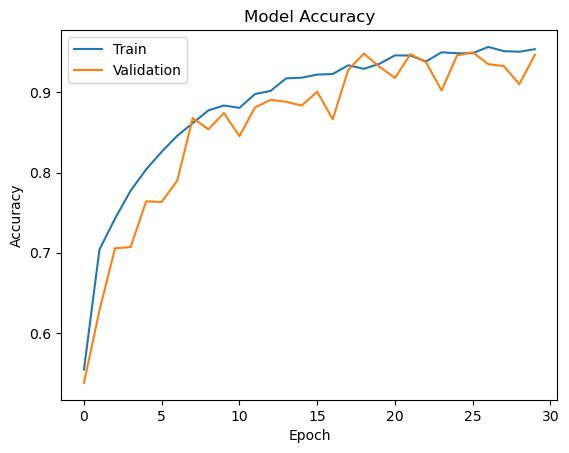

In [37]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

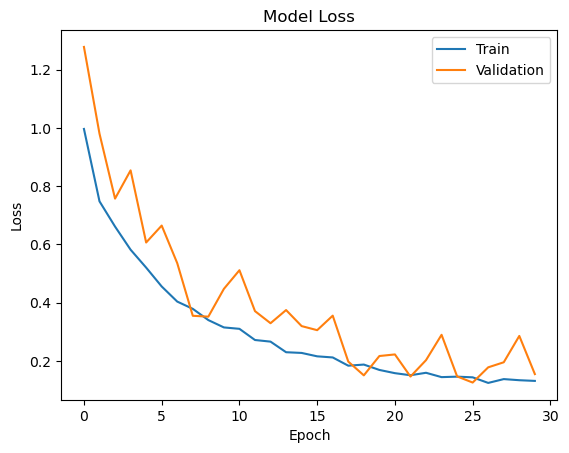

In [38]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

### STEP 9: EVALUATION

In [39]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 [==============================] - 7s 156ms/step - loss: 0.1546 - accuracy: 0.9469
Test Loss: 0.15463335812091827
Test Accuracy: 0.9468749761581421


### STEP 10: CONFUSION MATRIX AND EXPLANATION:

41/41 [==============================] - 8s 189ms/step


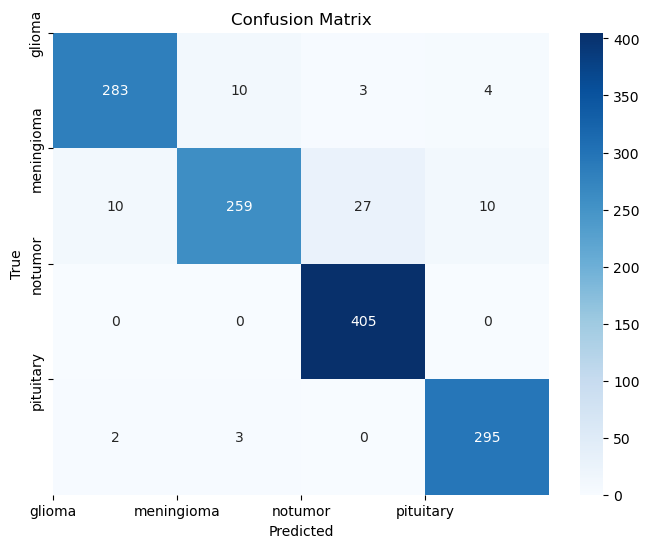

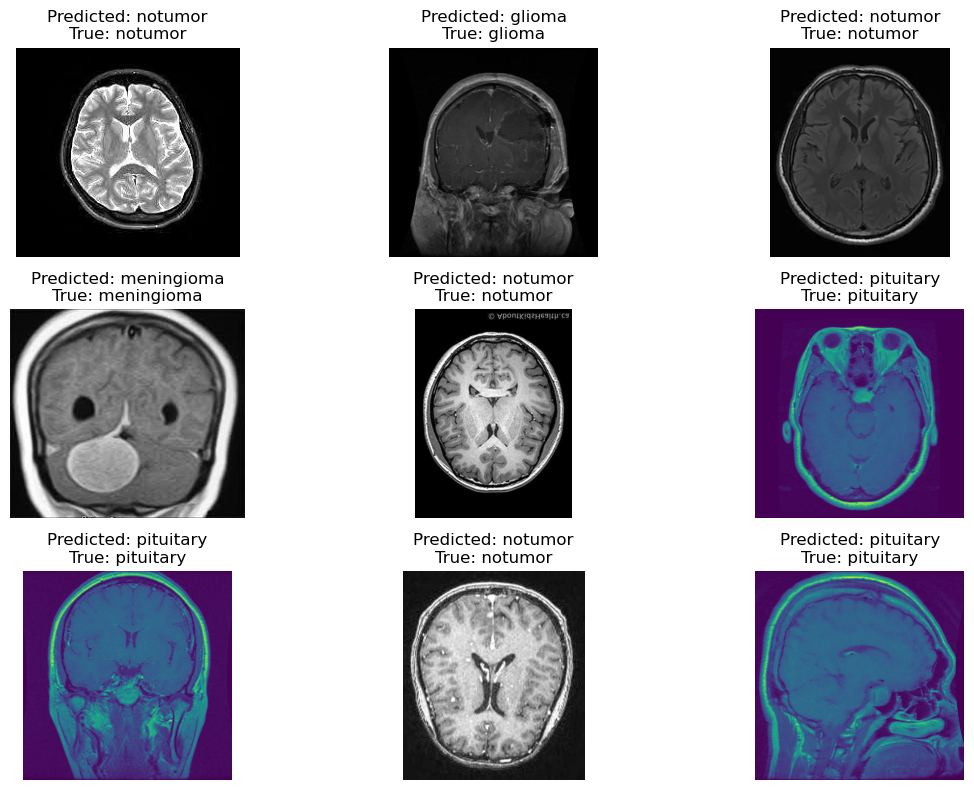

In [41]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Class: glioma
Precision: 0.9593220338983051
Recall: 0.9433333333333334
F1-Score: 0.9512605042016807

Class: meningioma
Precision: 0.9522058823529411
Recall: 0.8464052287581699
F1-Score: 0.8961937716262975

Class: notumor
Precision: 0.9310344827586207
Recall: 1.0
F1-Score: 0.9642857142857143

Class: pituitary
Precision: 0.9546925566343042
Recall: 0.9833333333333333
F1-Score: 0.9688013136288998



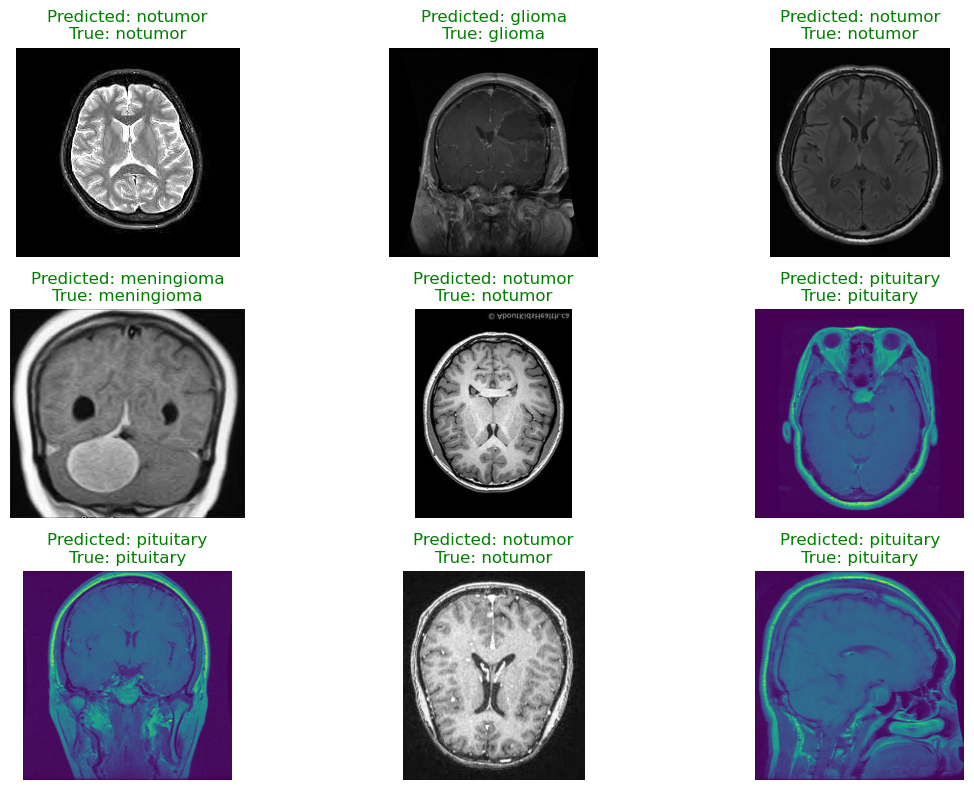

In [42]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [44]:
# Save the trained model
model.save("brain_tumor_LeNet.h5")


In [46]:
from sklearn.metrics import classification_report

# Calculate precision, recall, accuracy, and F1 score
report = classification_report(true_categories, predicted_categories, target_names=categories)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.94      0.95       300
  meningioma       0.95      0.85      0.90       306
     notumor       0.93      1.00      0.96       405
   pituitary       0.95      0.98      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.95      1311
weighted avg       0.95      0.95      0.95      1311

